<img src='baniere.png'>

# Collect Data / Set the types

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
train_data = pd.read_csv('train.csv')
X_train = train_data.drop(columns = 'consumption')
y_train = train_data['consumption']

In [3]:
#remove the '+3' in time feature in order to set the type to datetime64
def modif_date(df):
    for idx in range(df.shape[0]):
        df['time'][idx] = df['time'][idx].split('+')[0]
    df['time'] = df['time'].astype('datetime64[ns]')
    return(df)

In [4]:
#This cell takes more than 10 minutes to compute

#X_train = modif_date(X_train) 

In [5]:
#To save time every time we restart the kernel
X_train = pd.read_csv('X_train_modifTime').drop(columns = 'Unnamed: 0')
X_train['time'] = X_train['time'].astype('datetime64[ns]')

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8592 entries, 0 to 8591
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      8592 non-null   datetime64[ns]
 1   temp      8592 non-null   float64       
 2   dwpt      8592 non-null   float64       
 3   rhum      8592 non-null   float64       
 4   prcp      2159 non-null   float64       
 5   snow      119 non-null    float64       
 6   wdir      8592 non-null   float64       
 7   wspd      8592 non-null   float64       
 8   wpgt      8592 non-null   float64       
 9   pres      8592 non-null   float64       
 10  coco      8396 non-null   float64       
 11  el_price  8592 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 805.6 KB


# Cleaning the data

##### We have three problematic features:
* prcp with 75% of NaN
* snow with 99% of NaN
* coco with 2% of Nan (corresponding to the month of June 2022)

**Are prcp and snow important and correlated with energy consumption ?**

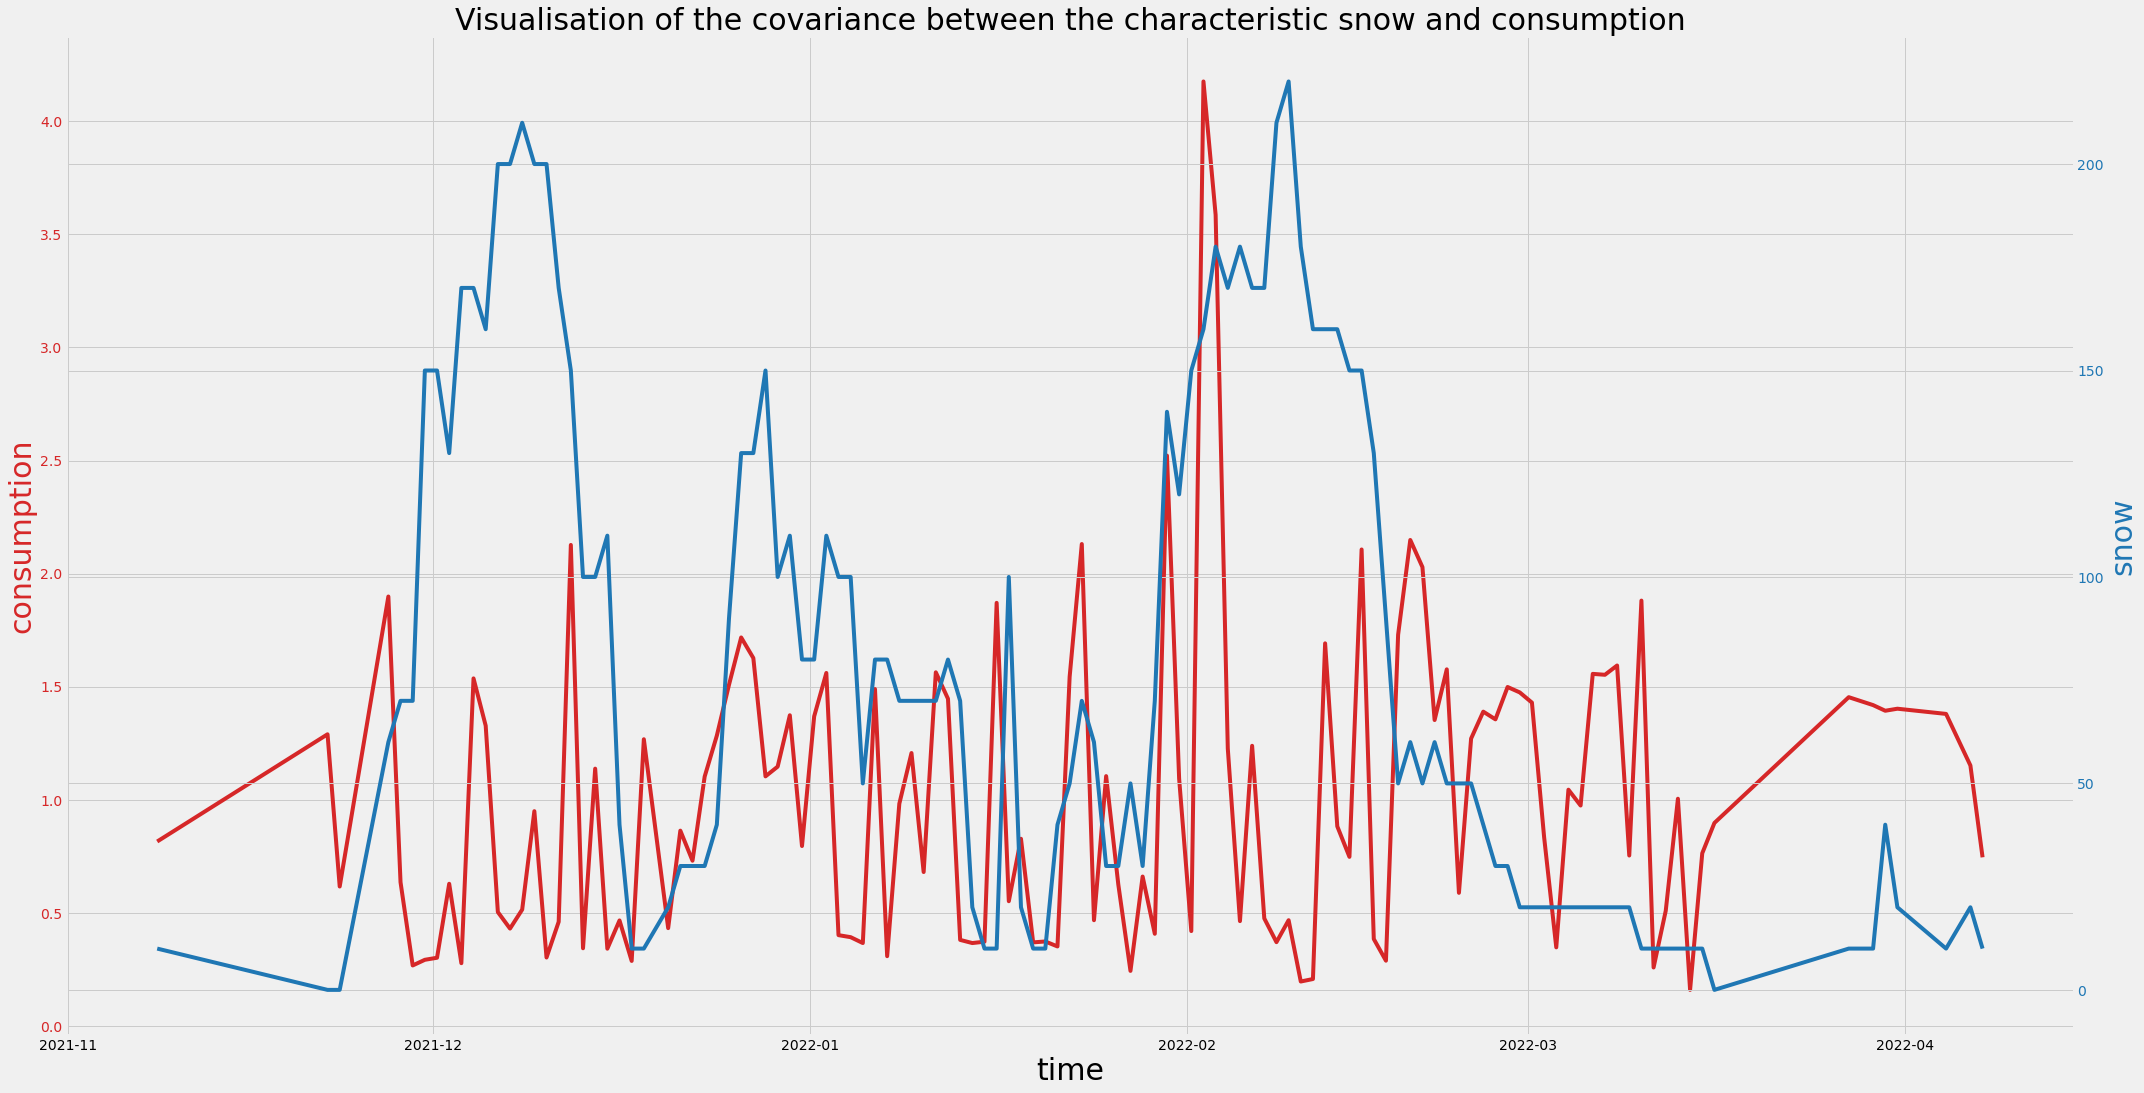

In [7]:
fig, ax1 = plt.subplots(figsize = (30,15))

color = 'tab:red'
ax1.set_xlabel('time', size=30)
ax1.set_ylabel('consumption', color=color, size=30)
ax1.plot(X_train['time'][~np.isnan(X_train['snow'])], y_train[~np.isnan(X_train['snow'])], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('snow', color=color, size=30)  # we already handled the x-label with ax1
ax2.plot(X_train['time'][~np.isnan(X_train['snow'])], X_train['snow'][~np.isnan(X_train['snow'])], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Visualisation of the covariance between the characteristic snow and consumption', size=30)
plt.show()

It is complicated to conclude on a possible correlation between these two routes. Indeed, on several occasions the variations of the two curves seem to occur together. 
Further analysis of the correlation indices is necessary. However, as 99% of the records are missing and we are trying to predict consumption during the month of August 2022 (Kaggle competition) when there is no snow, we decided to eliminate this feature from the dataset.

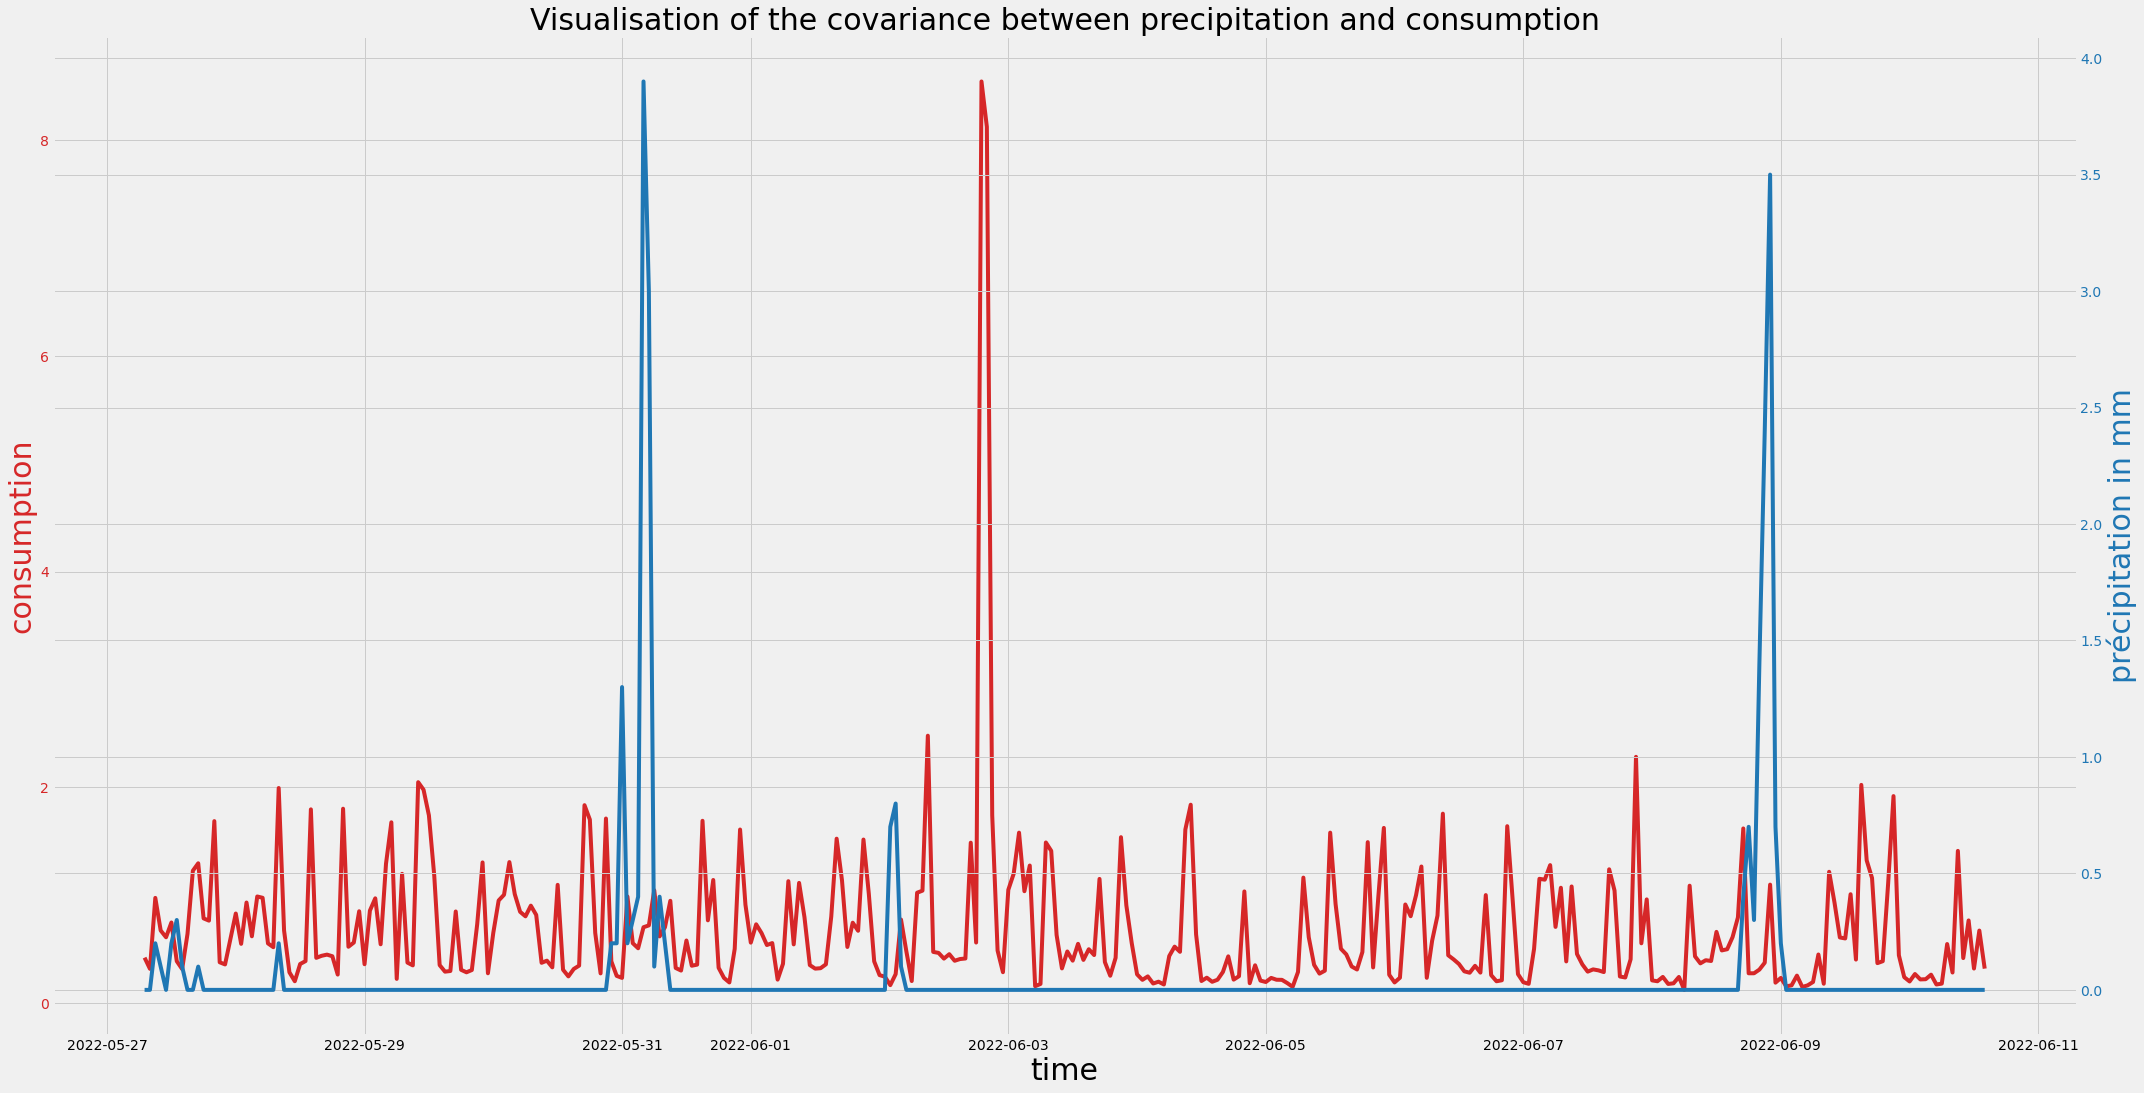

In [8]:
fig, ax1 = plt.subplots(figsize = (30,15))

color = 'tab:red'
ax1.set_xlabel('time', size=30)
ax1.set_ylabel('consumption', color=color, size=30)
ax1.plot(X_train['time'][~np.isnan(X_train['prcp'])].iloc[6:350], y_train[~np.isnan(X_train['prcp'])].iloc[6:350], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('précipitation in mm', color=color, size=30)  # we already handled the x-label with ax1
ax2.plot(X_train['time'][~np.isnan(X_train['prcp'])].iloc[6:350], X_train['prcp'][~np.isnan(X_train['prcp'])].iloc[6:350], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Visualisation of the covariance between precipitation and consumption', size=30)
plt.show()

We find that peak precipitation has no impact on energy consumption. For example, on this plot we see two significant precipitation peaks on 31 May 2022 and 8 June of the same year without any impact on the consumption plot.

In [9]:
X_train = X_train.drop(columns = ['prcp', 'snow'])  #Remove those two features

It is also necessary to look at the 'coconut' feature as it contains 2% NaN. The target data 'consumption' also has 2 missing values. We therefore decided:
* Replace the consumption records with the last valid previous record. In fact the difference in consumption from one hour to the next is minimal. 
* The missing values of 'coco' correspond to the month of June 2022.
We have therefore replaced the missing values with the average values for July 2022, which is close to the summer weather values.  

In [10]:
y_train = y_train.fillna(method="ffill")
X_train['coco'] = X_train['coco'].fillna(np.round(X_train['coco'][(X_train['time'] > '2022-07-01 00:00:00') & (X_train['time'] < '2022-07-31 00:00:00')].mean()))

# Feature Selection

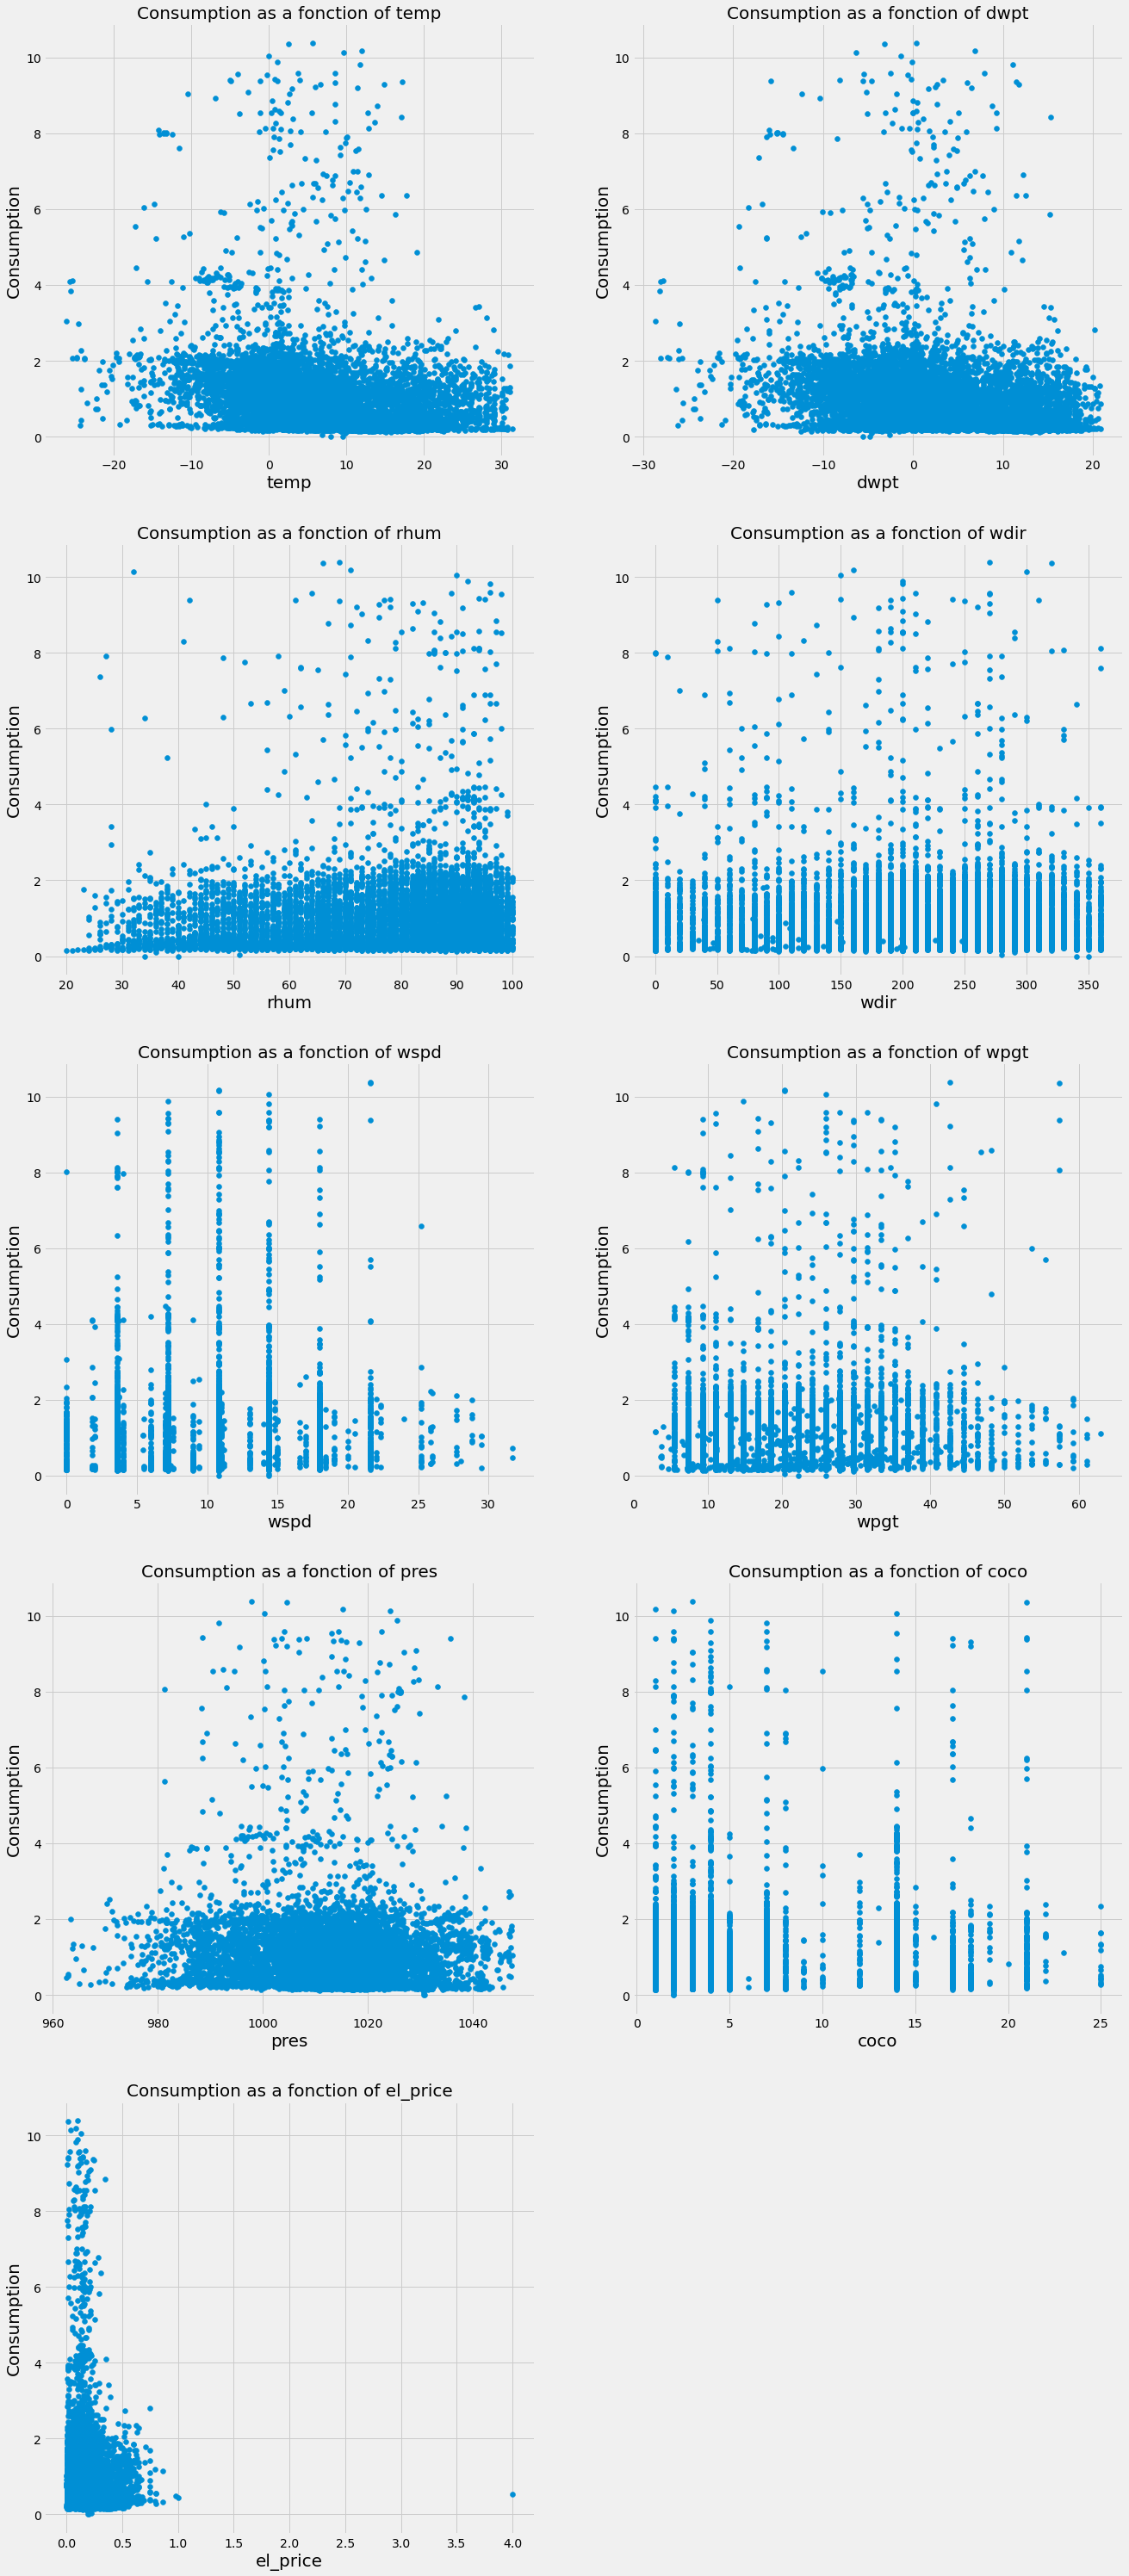

In [11]:
plt.figure(figsize = (20,50))
for i, feature in enumerate(X_train.drop(columns = 'time').columns):
    plt.subplot(5, 2, i+1)
    plt.scatter(X_train[feature], y_train)
    plt.title('Consumption as a fonction of '+ feature, size=20)
    plt.ylabel('Consumption', size=20)
    plt.xlabel(feature, size=20)
plt.show()

In [12]:
from sklearn.feature_selection import SelectKBest, r_regression
r_regression(X_train.drop(columns = 'time'), y_train)
#selector = SelectKBest(r_regression, k=2)
#selector.fit_transform(X_train.drop(columns = 'time'), y_train)
#selector.get_support()

array([-0.26783936, -0.25041597,  0.09444024, -0.00502601,  0.04885981,
        0.0721729 , -0.06892573,  0.13486032, -0.12479134])

C:\Users\theob\AppData\Local\Temp\ipykernel_9220\3339610646.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(X_train.drop(columns = 'time').columns, X_train.var(axis = 0))


[]

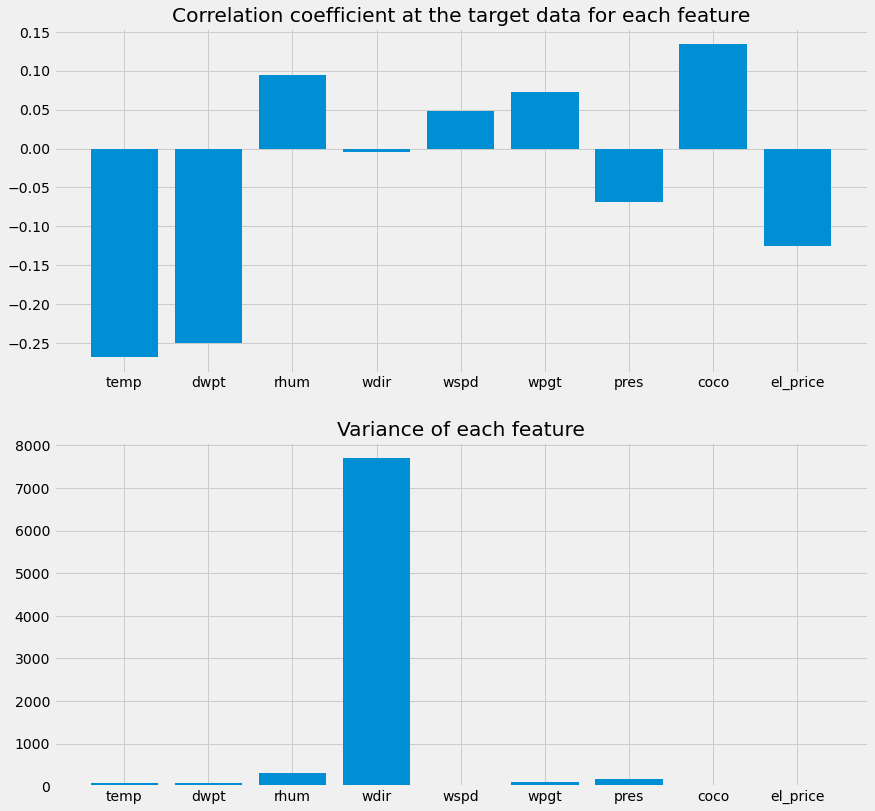

In [13]:
plt.figure(figsize=(13, 13))
plt.subplot(2, 1, 1)
plt.bar(X_train.drop(columns = 'time').columns, r_regression(X_train.drop(columns = 'time'), y_train))
plt.title('Correlation coefficient at the target data for each feature')
plt.subplot(2, 1, 2)
plt.bar(X_train.drop(columns = 'time').columns, X_train.var(axis = 0))
plt.title('Variance of each feature')
plt.plot()

# Out Layers 

[]

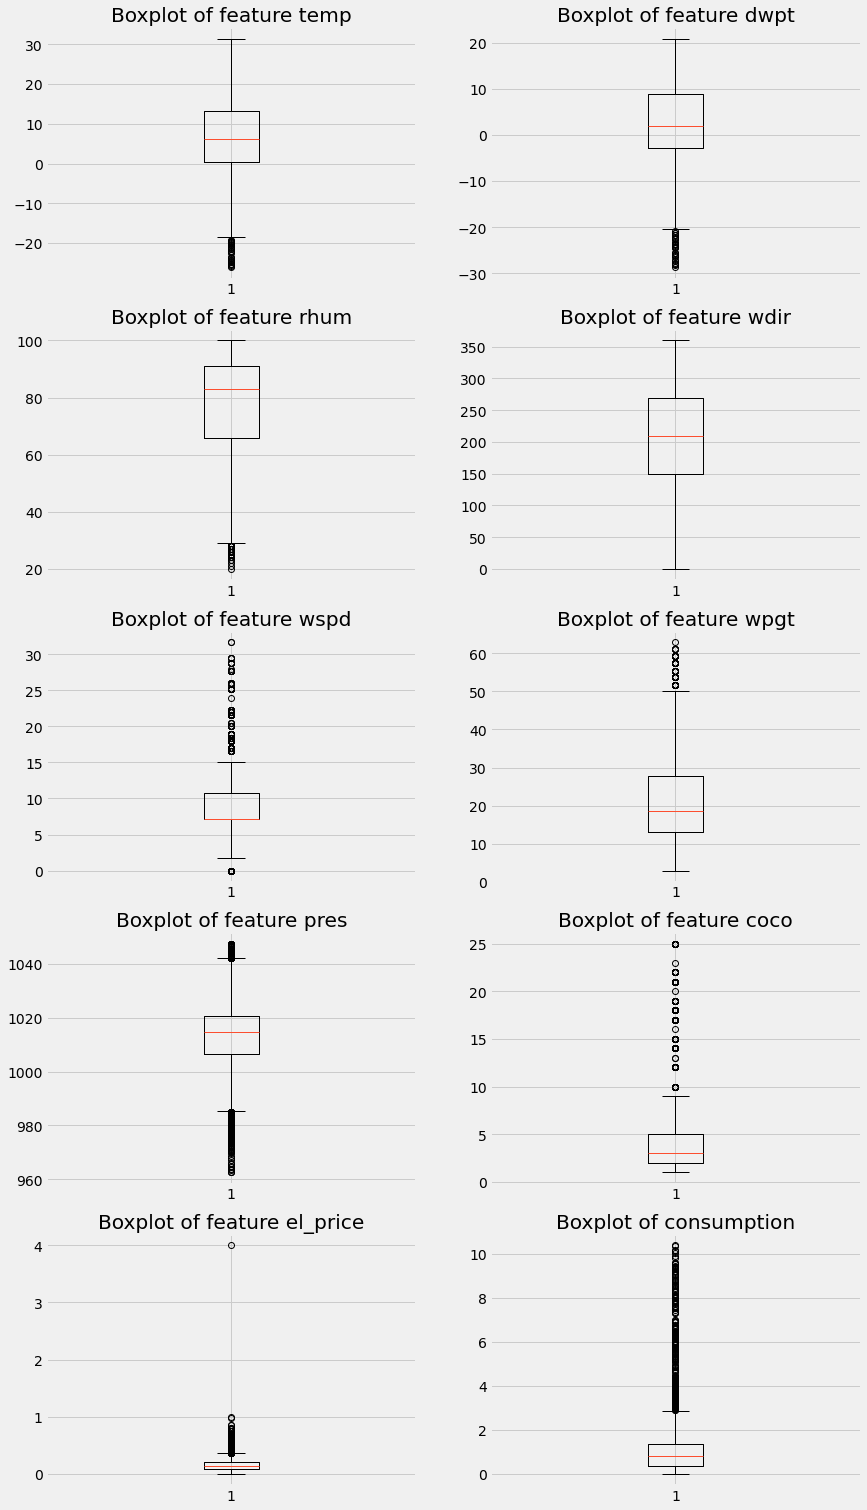

In [14]:
plt.figure(figsize = (13, 25))
for i, feature in enumerate(X_train.drop(columns = 'time').columns):
    plt.subplot(5, 2, i+1)
    plt.boxplot(X_train[feature])
    plt.title(f'Boxplot of feature {feature}')
plt.subplot(5, 2, 10)
plt.boxplot(y_train)
plt.title('Boxplot of consumption')
plt.plot()

Downstream research showed that removing outliers from features had no impact on prediction. However, removing the extreme values from the target data 'consumption' does improve the results. We therefore proceed with this removal. 

Text(0.5, 1.0, 'Visualisation of the out layers in the consumption data')

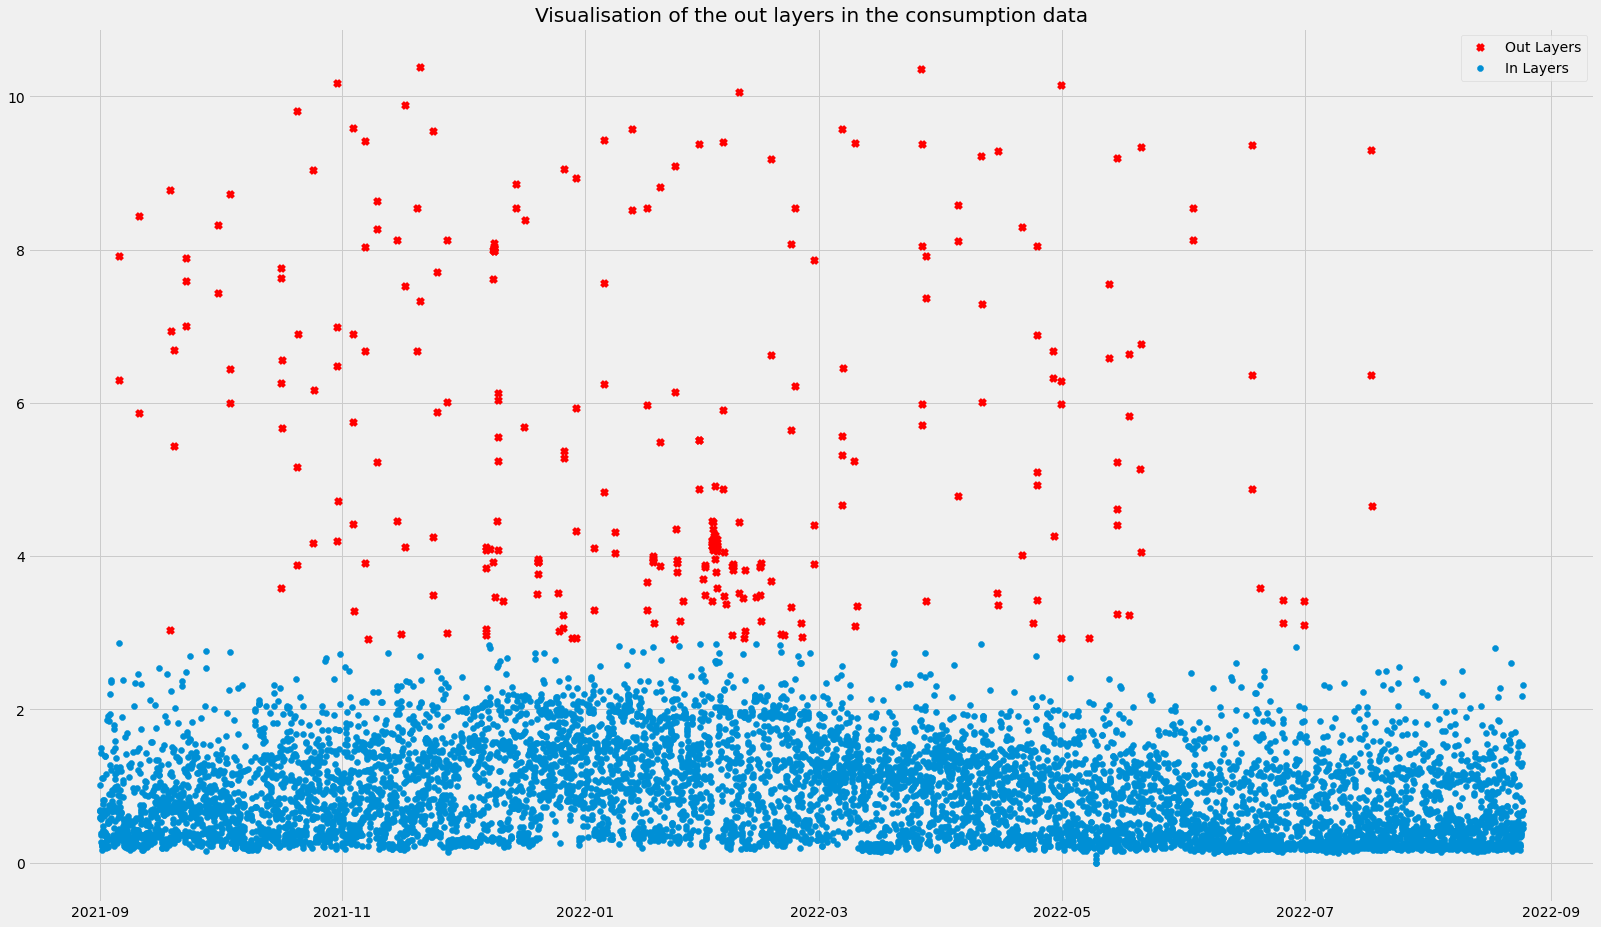

In [15]:
plt.figure(figsize = (25,15))
plt.scatter(X_train['time'].iloc[y_train[y_train > 2.869].index], y_train.iloc[y_train[y_train > 2.869].index], marker='x', c='red', label = 'Out Layers')
plt.scatter(X_train['time'].drop(y_train[y_train > 2.869].index), y_train.drop(y_train[y_train > 2.869].index), label='In Layers')
plt.legend()
plt.title('Visualisation of the out layers in the consumption data')

# Time Series

Before this project we had never worked with the Time Series. So we took the free Kaggle training course to get started. The link to this training is available in the annex.  

<img src='Beringuier_Time Series.png'>

##### Consideration of Lag 

In [16]:
#Create a new DataFrame consisting only of dates and consumptions

X_train_TS = pd.DataFrame({'time': X_train['time'],  
                          'consumption': y_train})
X_train_TS = X_train_TS.set_index('time')

In [17]:
#Create an offset of a record called 'Lag'

X_train_TS['Lag_1'] = X_train_TS['consumption'].shift(1)
X_train_TS = X_train_TS.reindex(columns=['consumption', 'Lag_1'])
X_train_TS

,consumption,Lag_1
time,,
2021-09-01 00:00:00,0.577,NaN
2021-09-01 01:00:00,0.594,0.577
2021-09-01 02:00:00,0.685,0.594
2021-09-01 03:00:00,1.016,0.685
2021-09-01 04:00:00,0.677,1.016
...,...,...
2022-08-24 19:00:00,0.678,0.619
2022-08-24 20:00:00,0.457,0.678
2022-08-24 21:00:00,0.500,0.457


Text(0.5, 1.0, 'Lag Plot of consumption')

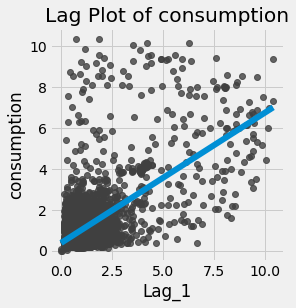

In [18]:
import seaborn as sns
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='consumption', data=X_train_TS, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of consumption')

You can see from the lag plot that consumption on one day is correlated with the consumption from 
the previous day. That means Lag feature can be helpful.

#### Moving average

In [19]:
y_train_mov = pd.DataFrame({})
y_train_mov['consumption'] = y_train
y_train_mov['time'] = X_train['time']
y_train_mov = y_train_mov.set_index('time')
y_train_mov

,consumption
time,
2021-09-01 00:00:00,0.577
2021-09-01 01:00:00,0.594
2021-09-01 02:00:00,0.685
2021-09-01 03:00:00,1.016
2021-09-01 04:00:00,0.677
...,...
2022-08-24 19:00:00,0.678
2022-08-24 20:00:00,0.457
2022-08-24 21:00:00,0.500


<Figure size 1440x1080 with 0 Axes>

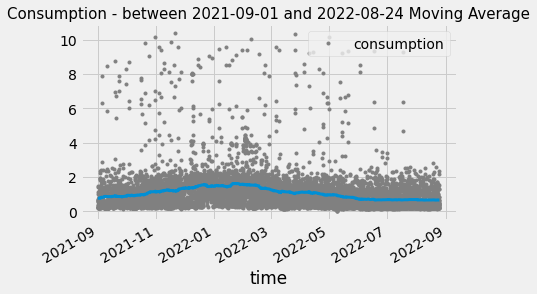

In [20]:
y_train_mov = pd.DataFrame({})
y_train_mov['consumption'] = y_train
y_train_mov['time'] = X_train['time']
y_train_mov = y_train_mov.set_index('time')

moving_average = y_train_mov.rolling(
    window=720,       # 30-day window
    center=True,      # puts the average at the center of the window
    min_periods=360,  # choose about half the window size
).mean()              

plt.figure(figsize=(20,15))
ax = y_train_mov.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, legend=False)
plt.title("Consumption - between 2021-09-01 and 2022-08-24 Moving Average", size = 15)
plt.show()

We can see that the rolling average of the consumption data shows a maximum consumption in the winter period

##### Trend of the consumption during time

In [21]:
date = pd.Timestamp('2022-08-24 23:00:00')
index_fore = []
for iteration in range(168):
    heure = date.hour
    jour = date.day
    mois = date.month
    if heure != 23:
        heure += 1
    else:
        heure = 0
        jour += 1
    try:
        (pd.Timestamp(month=mois, day=jour, hour=heure))
    except: 
        if (date.day > 31):
            mois += 1
            jour = 1
    date = pd.Timestamp(year=2022, month=mois, day=jour, hour=heure)
    index_fore.append(date)

In [22]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = X_train_TS['consumption'].copy()

dp = DeterministicProcess(index=y.index, order=3)  #Power 1, 2 and 3
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=168)  #redict the trend for 7 days (test shape)
X_fore['time'] = index_fore
X_fore = X_fore.set_index('time')

C:\Users\theob\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [23]:
X

,trend,trend_squared,trend_cubed
time,,,
2021-09-01 00:00:00,1.0,1.0,1.000000e+00
2021-09-01 01:00:00,2.0,4.0,8.000000e+00
2021-09-01 02:00:00,3.0,9.0,2.700000e+01
2021-09-01 03:00:00,4.0,16.0,6.400000e+01
2021-09-01 04:00:00,5.0,25.0,1.250000e+02
...,...,...,...
2022-08-24 19:00:00,8588.0,73753744.0,6.333972e+11
2022-08-24 20:00:00,8589.0,73770921.0,6.336184e+11
2022-08-24 21:00:00,8590.0,73788100.0,6.338398e+11


Train a linear regression to predict te trend feature

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()  
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index) #same as test.csv

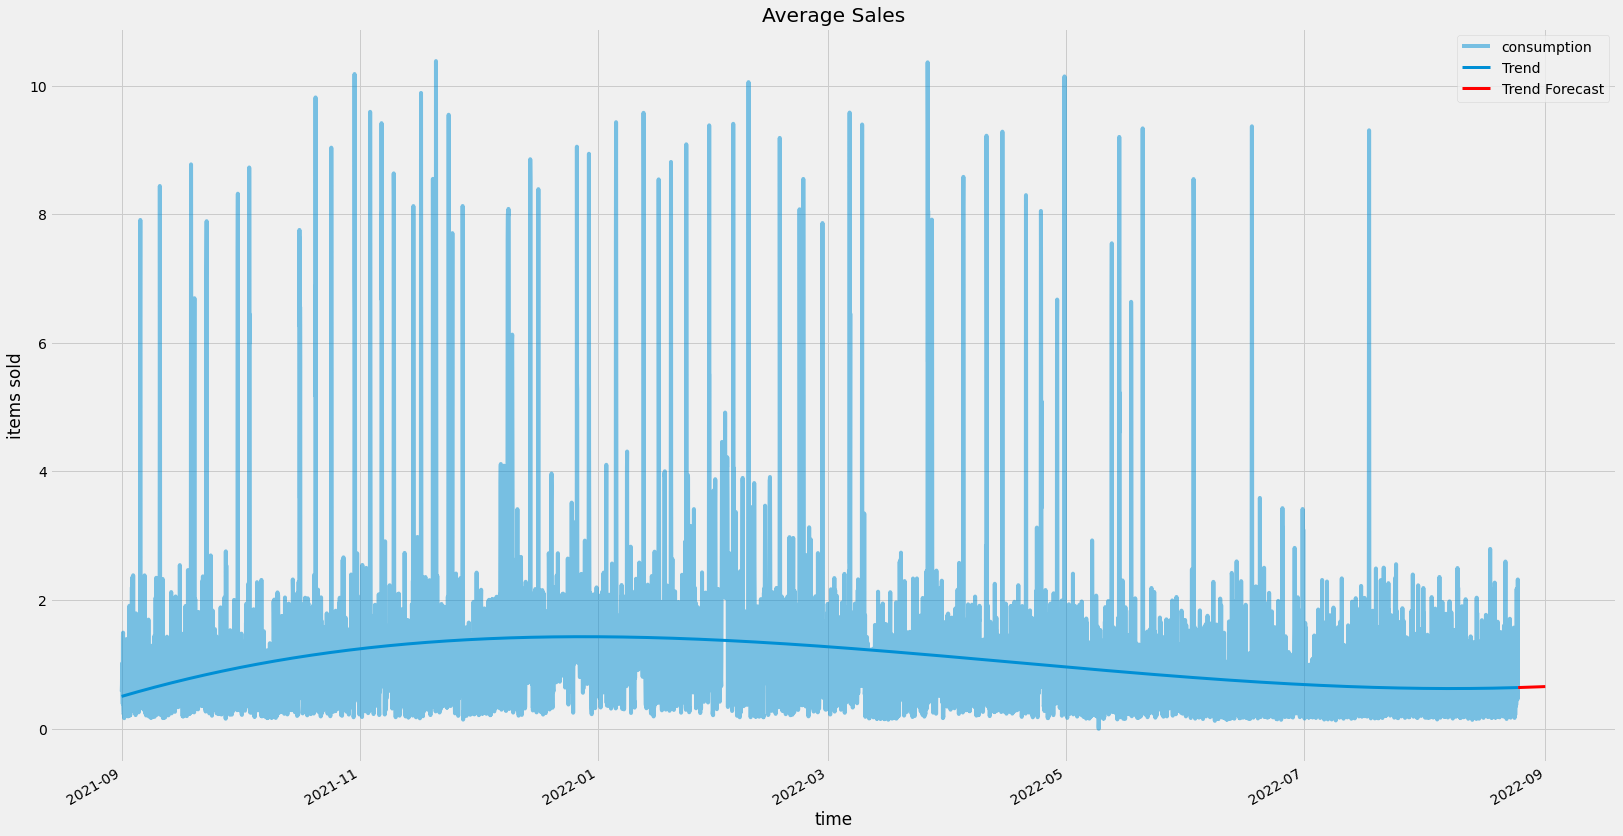

In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

plt.figure(figsize = (25,15))
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='red')
ax.legend();

In [26]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [27]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax
 

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual",
            "Semiannual",
            "Quarterly",
            "Bimonthly",
            "Monthly",
            "Biweekly",
            "Weekly",
            "Semiweekly",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

#data_dir = Path("../input/ts-course-data")
#tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
#tunnel = tunnel.set_index("Day").to_period("D")

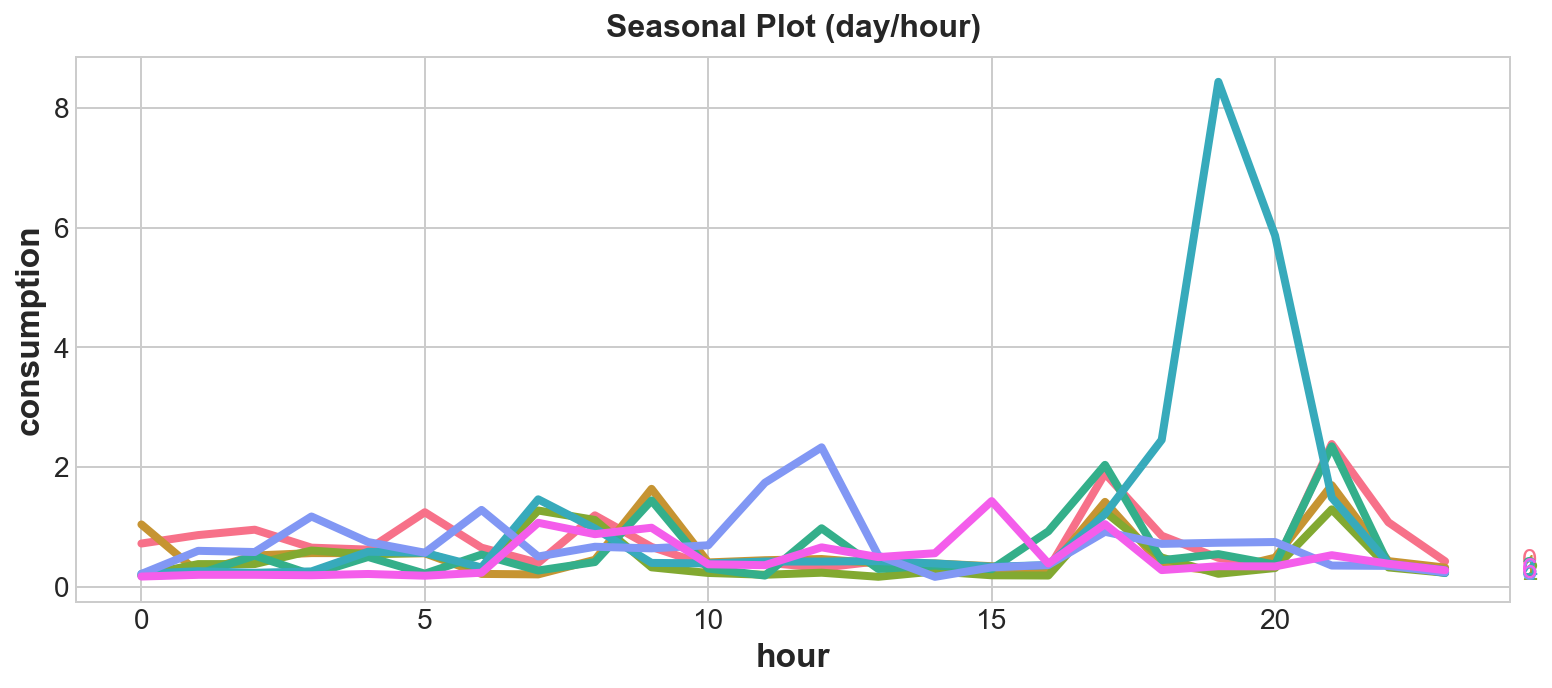

In [28]:
X = X_train_TS['consumption'].to_frame()
#X.index = X.index.astype('period[D]')
# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
week = X.index.week  # the seasonal period (period)
X["week"] = week
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X['hour'] =X.index.hour

X = X[X.index < pd.to_datetime('2021-09-13 00:00:00')]
X = X[X.index > pd.to_datetime('2021-09-05 23:00:00')]

seasonal_plot(X, y='consumption', period='day', freq='hour');


The most interesting thing for us was to see if there was any seasonality in the consumption data on a daily basis. Indeed we don't see much we would consume more energy on the moon than on Tuesday for example whereas in a day it would be more logical to consume more around 19~20h for example because people cook and thus use ovens and hotplates. However we do not see such seasonality in the data. To illustrate this we have displayed the energy consumption hour by hour for 7 days corresponding to the randomly selected week of 6-12 September.

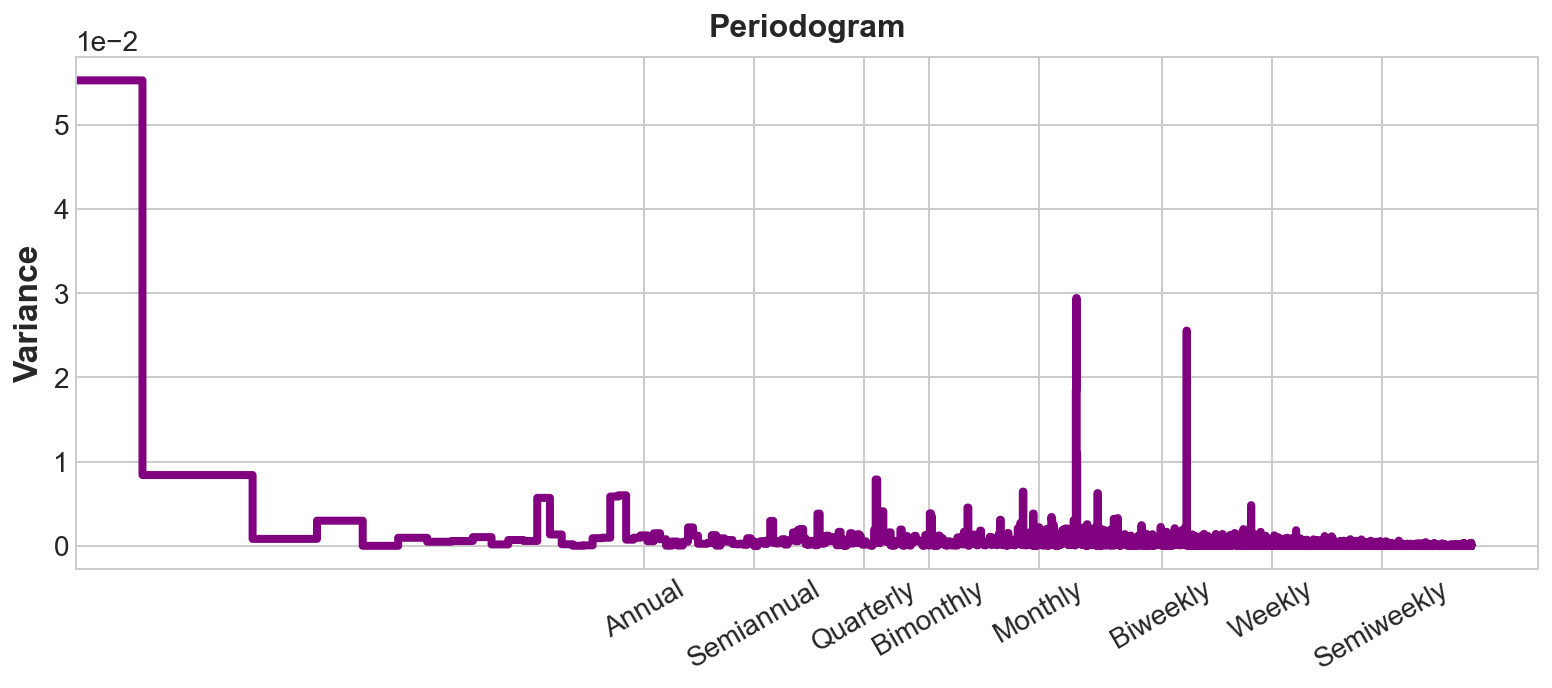

In [29]:
plot_periodogram(X_train_TS['consumption']);

In the end, and as we can also see from the periodogram, there is very little seasonality in the consumption data and we do not think that this will add anything to our model. 

# Models / Submissions

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
rf = RandomForestRegressor().fit(X_train.drop(columns = 'time'), y_train)

In [32]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
df = X_train_TS

In [33]:
def create_feature(df):    #Make some feature engeneering
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return(df)

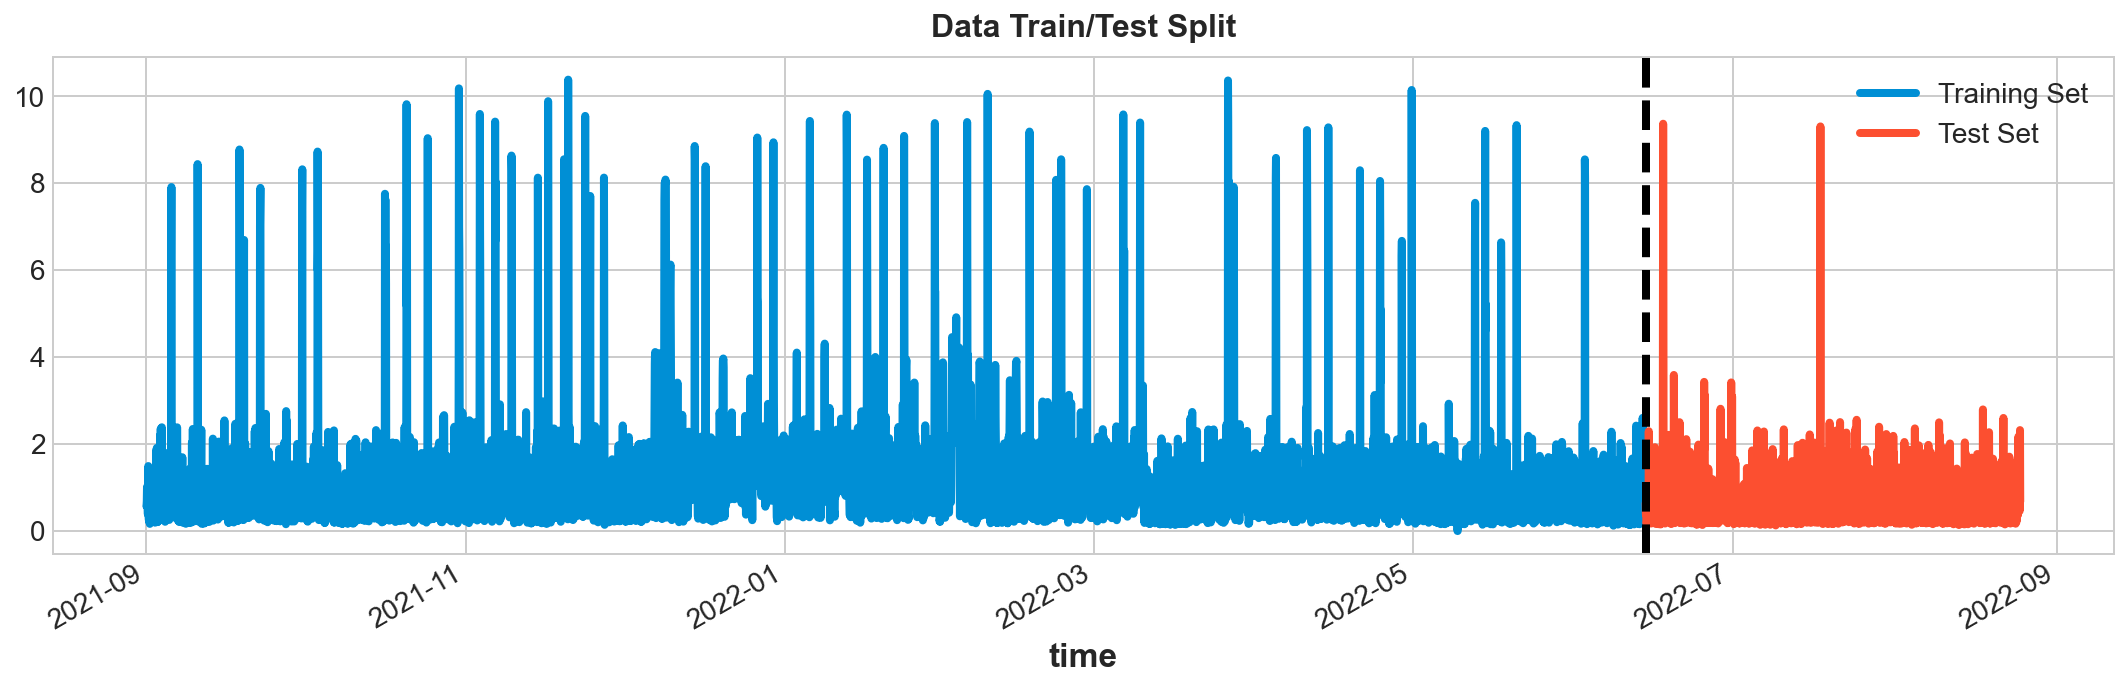

In [34]:
train = df['consumption'].loc[df.index < '2022-06-14 10:00:00'] #80% of the data
test = df['consumption'].loc[df.index >= '2022-06-14 10:00:00'] #20% of it

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-06-14 10:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [35]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=800, gap=24)
df = df.sort_index()

We can use K-Fold Validation to try our different models

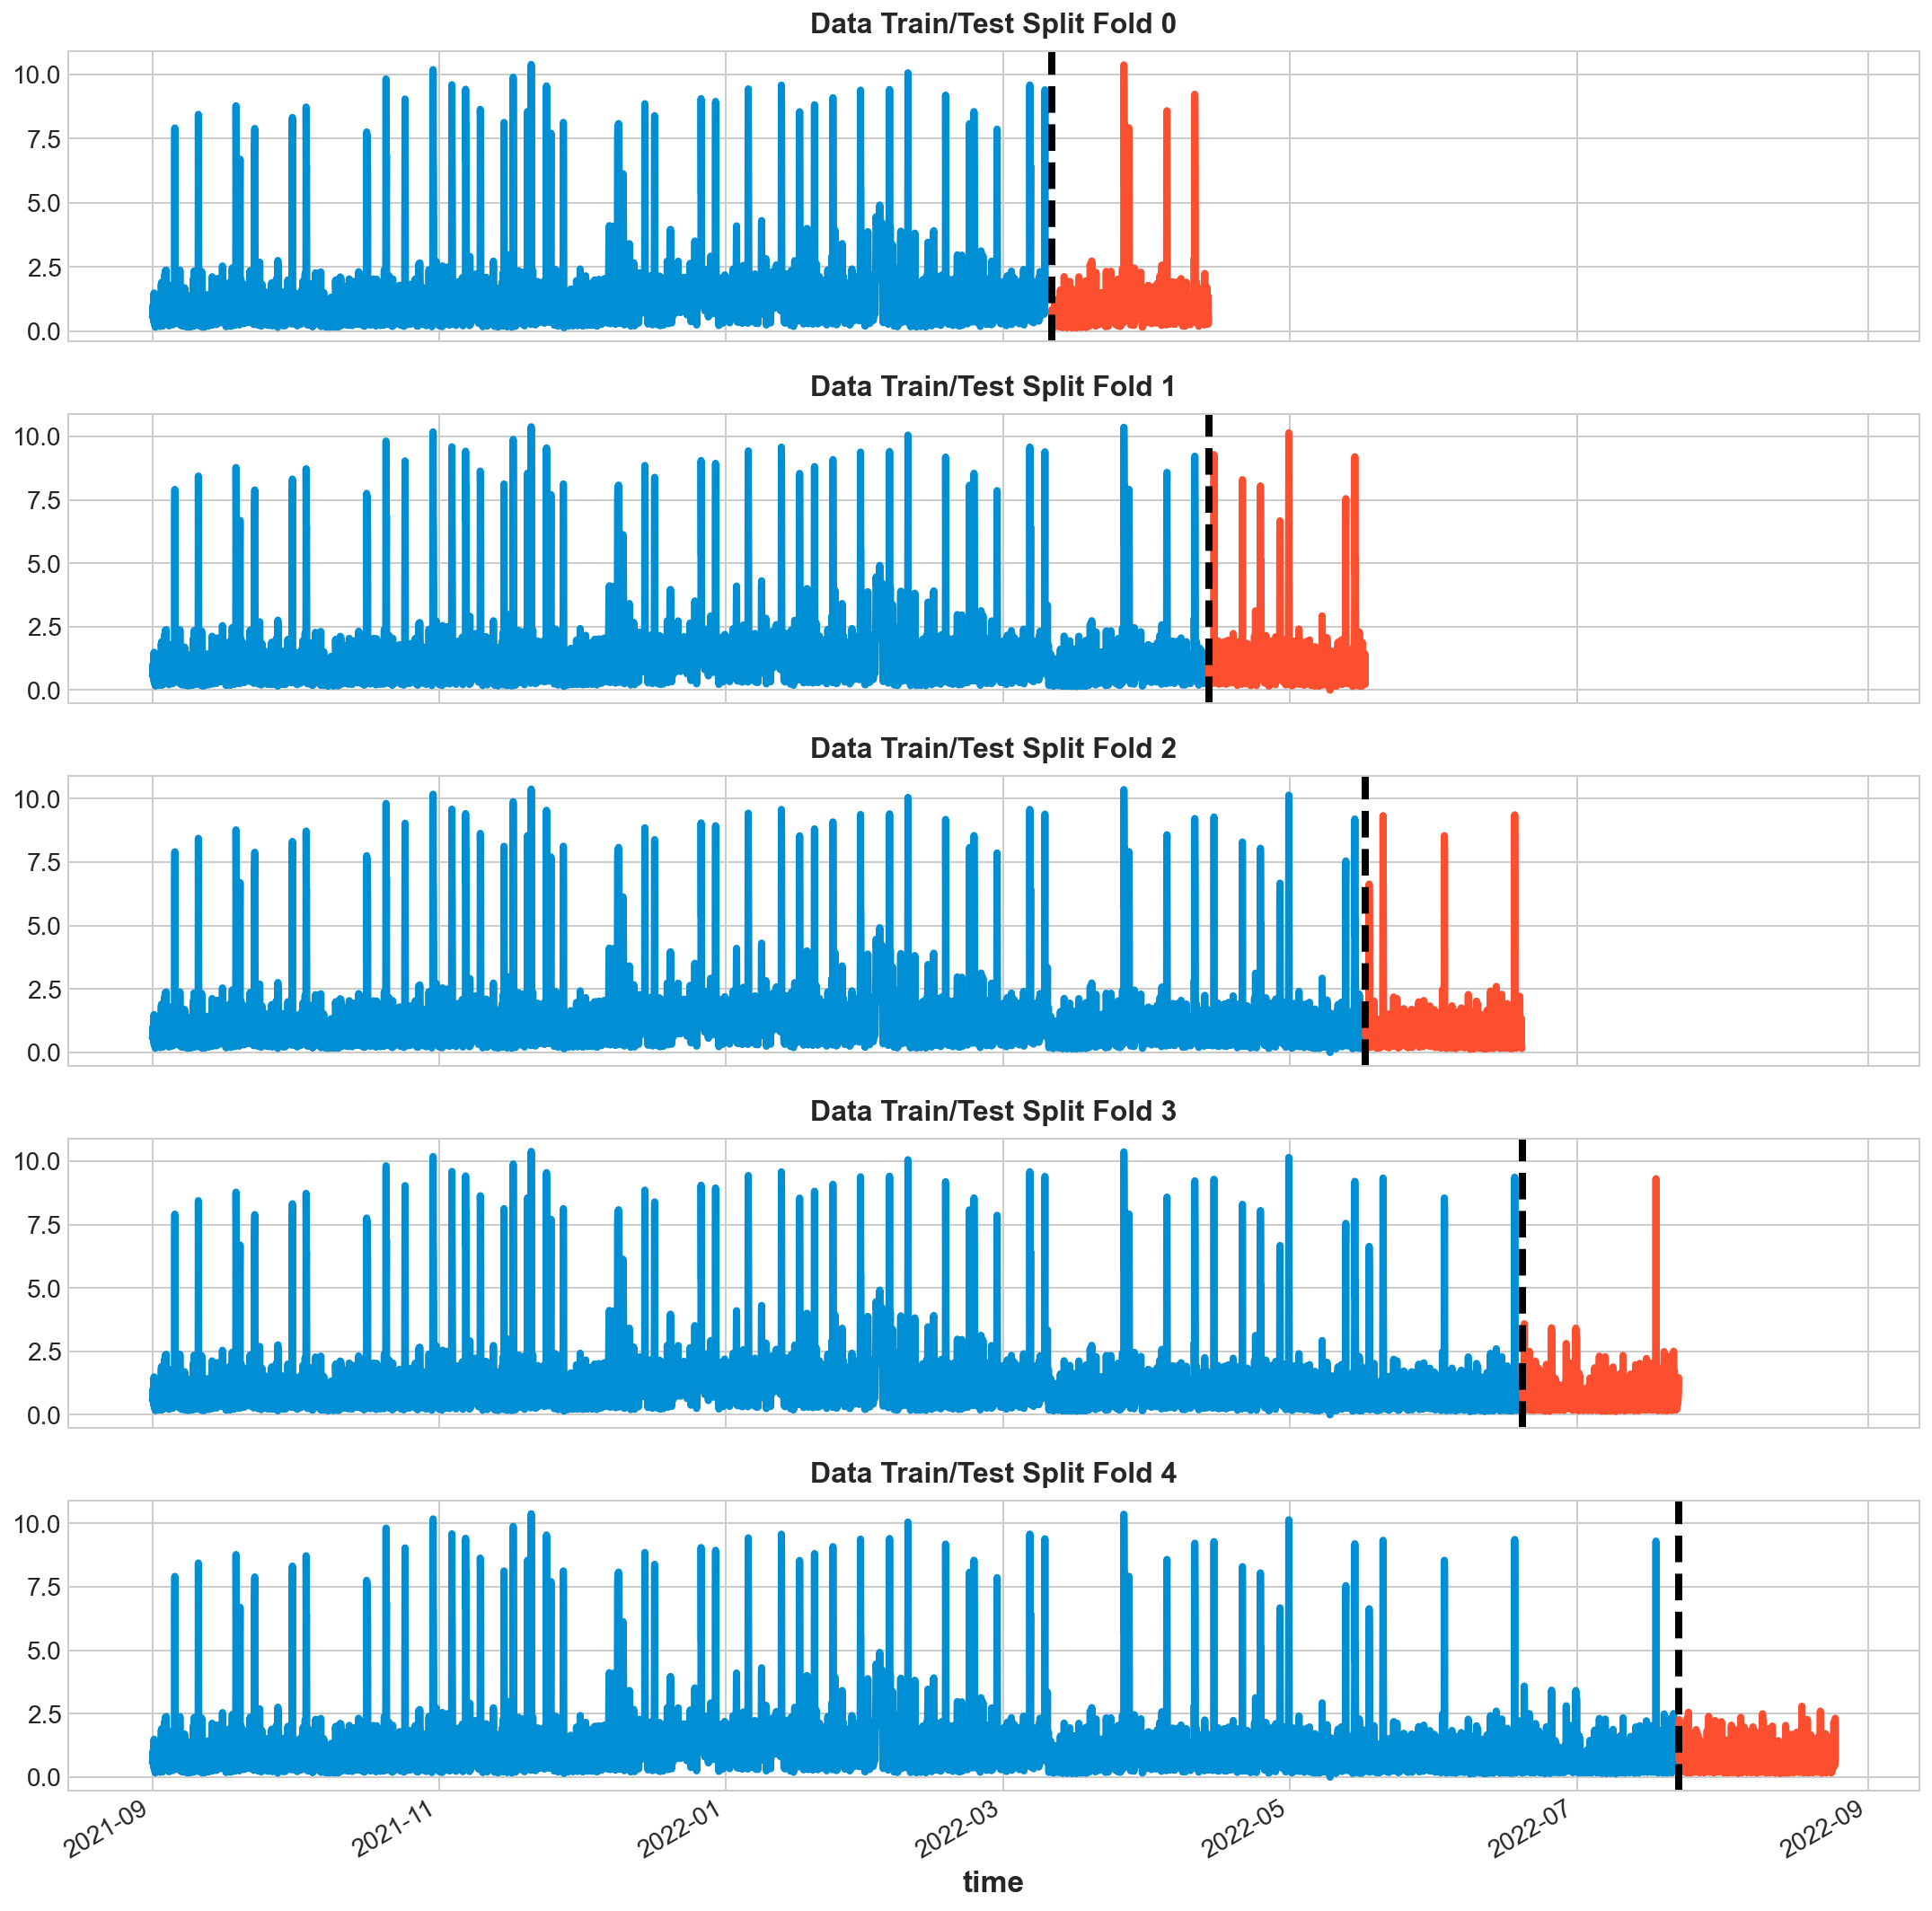

In [36]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df['consumption'].iloc[train_idx]
    test = df['consumption'].iloc[val_idx]
    train.plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test.plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Prepare the data to fit a model

In [37]:
df = create_feature(df)
df['trend'] = y_pred

In [38]:
X_train['consumption'] = y_train

In [39]:
test_sub = pd.read_csv('test.csv')
test_sub = modif_date(test_sub)
test_sub = test_sub.set_index('time')
test_sub = create_feature(test_sub)
test_sub['trend'] = y_fore
test_sub['Lag_7day_before'] = X_train['consumption'].iloc[8424:].to_list()
test_sub['Lag_7day_after'] = X_train['consumption'].iloc[:168].to_list()
test_sub

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,...,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,trend,Lag_7day_before,Lag_7day_after
time,,,,,,,,,,,,,,,,,,,,,
2022-08-25 00:00:00,21.1,15.2,69.0,0.0,NaN,340.0,9.0,9.3,1022.0,2.0,...,3,3,8,2022,237,25,34,0.640232,0.245,0.577
2022-08-25 01:00:00,20.1,15.1,73.0,0.0,NaN,30.0,6.0,14.8,1022.0,2.0,...,3,3,8,2022,237,25,34,0.640308,0.178,0.594
2022-08-25 02:00:00,20.1,15.1,73.0,0.0,NaN,320.0,7.0,13.0,1022.0,2.0,...,3,3,8,2022,237,25,34,0.640384,0.203,0.685
2022-08-25 03:00:00,18.7,17.0,90.0,0.0,NaN,0.0,4.0,11.1,1022.4,4.0,...,3,3,8,2022,237,25,34,0.640460,0.215,1.016
2022-08-25 04:00:00,18.1,17.1,94.0,0.0,NaN,280.0,7.0,11.1,1022.0,3.0,...,3,3,8,2022,237,25,34,0.640537,1.043,0.677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,11.1,6.0,71.0,0.0,NaN,320.0,19.0,29.6,1016.0,3.0,...,2,3,8,2022,243,31,35,0.655220,0.678,0.258
2022-08-31 20:00:00,11.1,5.2,67.0,0.0,NaN,310.0,15.0,24.1,1016.0,3.0,...,2,3,8,2022,243,31,35,0.655328,0.457,0.485
2022-08-31 21:00:00,10.1,6.3,77.0,0.0,NaN,290.0,11.0,22.2,1016.9,4.0,...,2,3,8,2022,243,31,35,0.655437,0.500,1.697


In [40]:
X_train_out_cons = pd.DataFrame({})
X_train_out_cons['Lag_7day_before'] = X_train['consumption'].shift(169)
X_train_out_cons['Lag_7day_after'] = X_train['consumption'].shift(-169)
X_train_out_cons['idx'] = X_train_out_cons.index
X_train_out_cons['time'] = X_train['time']
X_train_out_cons = X_train_out_cons.set_index('time')
X_train_out_cons['trend'] = y_pred
X_train_out_cons = X_train_out_cons.set_index('idx')
X_train_out_cons['temp'] = X_train['temp']
X_train_out_cons['dwpt'] = X_train['dwpt']
X_train_out_cons['consumption'] = X_train['consumption']

outliers = list()
#outliers.append(data_outlayers[data_outlayers['temp'] < -18.4].index.tolist())
#outliers.append(data_outlayers[data_outlayers['dwpt'] < -20.3].index.tolist())
#outliers.append(data_outlayers[data_outlayers['rhum'] < 29].index.tolist())
#outliers.append(data_outlayers[data_outlayers['wspd'] > 15].index.tolist())
#outliers.append(data_outlayers[data_outlayers['wspd'] < 1.8].index.tolist())
#outliers.append(data_outlayers[data_outlayers['wpgt'] > 50].index.tolist())
#outliers.append(data_outlayers[data_outlayers['pres'] > 1042].index.tolist())
#outliers.append(data_outlayers[data_outlayers['pres'] < 985.2].index.tolist())
#outliers.append(data_outlayers[data_outlayers['coco'] > 9].index.tolist())
#outliers.append(data_outlayers[data_outlayers['el_price'] > 2].index.tolist())
outliers.append(X_train_out_cons[X_train_out_cons['consumption'] > 2.869].index.tolist())
liste=[]
for val in outliers:
    liste+=val
    
outliers_ar = np.array(liste)
np.unique(outliers_ar)
outliers_ar.sort()
X_train_out_cons = X_train_out_cons.drop(outliers_ar, axis=0)

X_train_out_cons['time'] = X_train['time']
X_train_out_cons = X_train_out_cons.set_index('time')
X_train_out_cons = create_feature(X_train_out_cons)
X_train_out_cons

,Lag_7day_before,Lag_7day_after,trend,temp,dwpt,consumption,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
time,,,,,,,,,,,,,,
2021-09-01 00:00:00,NaN,0.378,0.502847,11.2,10.3,0.577,0,2,3,9,2021,244,1,35
2021-09-01 01:00:00,NaN,0.379,0.503586,10.7,9.6,0.594,1,2,3,9,2021,244,1,35
2021-09-01 02:00:00,NaN,0.605,0.504324,9.9,9.0,0.685,2,2,3,9,2021,244,1,35
2021-09-01 03:00:00,NaN,0.540,0.505062,10.0,8.4,1.016,3,2,3,9,2021,244,1,35
2021-09-01 04:00:00,NaN,0.565,0.505800,9.0,8.1,0.677,4,2,3,9,2021,244,1,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-24 19:00:00,0.528,NaN,0.639856,27.1,17.0,0.678,19,2,3,8,2022,236,24,34
2022-08-24 20:00:00,0.897,NaN,0.639931,25.1,17.1,0.457,20,2,3,8,2022,236,24,34
2022-08-24 21:00:00,2.796,NaN,0.640006,24.9,18.1,0.500,21,2,3,8,2022,236,24,34


Fit with K-fold to approximate the kaggle score

In [41]:
from sklearn.metrics import mean_absolute_error
tss = TimeSeriesSplit(n_splits=5, test_size=800, gap=24)
df = X_train_out_cons


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #train = create_features(train)
    #test = create_features(test)['hour', 'dayofweek', 'quarter', 'month', 'trend']

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
            'trend']
    TARGET = 'consumption'

    X_train_xgb = train[FEATURES]
    y_train_xgb = train[TARGET]
    
    X_test_xgb = test[FEATURES]
    y_test_xbg = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=75,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.01)
    reg.fit(X_train_xgb, y_train_xgb,
            eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xbg)],
            verbose=100)

    y_pred_xgb = reg.predict(X_test_xgb)
    preds.append(y_pred)
    score = mean_absolute_error(y_test_xbg, y_pred_xgb)
    scores.append(score)

[19:16:50] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:16:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:0.80594	validation_1-rmse:0.70589
[100]	validation_0-rmse:0.54778	validation_1-rmse:0.55276
[200]	validation_0-rmse:0.48319	validation_1-rmse:0.50792
[300]	validation_0-rmse:0.46041	validation_1-rmse:0.49845
[400]	validation_0-rmse:0.44852	validation_1-rmse:0.49659
[500]	validation_0-rmse:0.44111	validation_1-rmse:0.49661
[600]	validat

In [42]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.3846
Fold scores:[0.387352980671525, 0.3911112650051713, 0.40108242625325924, 0.3994334674088657, 0.3439820657889545]


Fit with the all dataset

In [43]:
df = X_train_out_cons

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
            'trend', 'Lag_7day_before', 'Lag_7day_after', 'temp']
TARGET = 'consumption'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth = 5,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[19:17:08] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.70726
[100]	validation_0-rmse:0.51709
[200]	validation_0-rmse:0.47147
[300]	validation_0-rmse:0.45413
[400]	validation_0-rmse:0.44469
[500]	validation_0-rmse:0.43908
[600]	validation_0-rmse:0.43354
[700]	validation_0-rmse:0.42955
[800]	validation_0-rmse:0.42607
[900]	validation_0-rmse:0.42304
[999]	validation_0-rmse:0.41990


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

Predict and put in the good shape for Kaggle

In [44]:
test_no_modif = pd.read_csv('test.csv')
sub_xgboost = pd.DataFrame({'time': test_sub.index,
                   'consumption': reg.predict(test_sub[FEATURES])})
sub_xgboost['time'] = test_no_modif['time']
sub_xgboost = sub_xgboost.set_index('time')

sub_xgboost.to_csv('xgboost_outlayers_cons_lag_temp_2.csv')

# Annexe

Kaggle [course](https://www.kaggle.com/learn/time-series) on TimeSeries. And [notebook](https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost) on xgboost.